## Problem 2
### Milad Heidari
### Student Number: 98101469

In [1]:
import torch
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
from torchvision.transforms import ToTensor

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, examples, labels, transform=None, target_transform=None):
        self.examples = examples
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        example = self.examples[idx, :]
        label = self.labels[idx]
        if self.transform is not None:
            example = self.transform(example)
        if self.target_transform is not None:
            label = self.target_transform(label)
                                    
        return example, label

In [4]:
# creating training and test set
df_train = pd.read_csv('data/Q3_train.csv').to_numpy()
df_test = pd.read_csv('data/Q3_test.csv').to_numpy()

train_set = CustomDataset(
    df_train[:, 1:],
    df_train[:, 0],
    transform=lambda x: torch.tensor(x).to(device),
    target_transform=lambda x: torch.tensor(x).to(device),
)

test_set = CustomDataset(
    df_test[:, 1:],
    df_test[:, 0],
    transform=lambda x: torch.tensor(x).to(device),
    target_transform=lambda x: torch.tensor(x).to(device),
)

#### A)

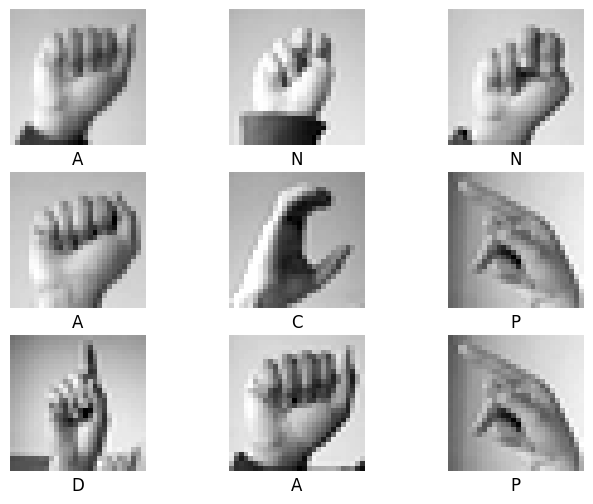

In [32]:
sample_dataloader = DataLoader(train_set, shuffle=True)
data_iterator = iter(sample_dataloader)

fig = plt.figure(figsize=(8, 6))
for i in range(1, 10):
    X, y = next(data_iterator)
    ax = fig.add_subplot(3, 3, i)
    ax.set_axis_off()
    ax.imshow(X.cpu().squeeze().reshape((28, 28)), cmap='gray')
    ax.set_title(chr(65 + y.cpu()), y=-0.2)

#### B)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(784, affine=False),
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [7]:
# create an instance of the model defined above
model = NeuralNetwork().to(device)
model.train()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=250, bias=True)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=60, bias=True)
    (6): ReLU()
    (7): Linear(in_features=60, out_features=26, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [8]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 15

In [9]:
# initialize the cost function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, train_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if save_losses:
            if batch_num % 100 == 0:
                train_losses.append(loss.item())
        
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100, 2)}%')
    
            
def test_loop(dataloader, model, loss_fn, test_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
            
            if save_losses:
                if batch_num % 100 == 0:
                    test_losses.append(loss.item())
        
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [11]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
train_losses = []
test_losses = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses=train_losses, save_losses=True)
    test_loop(test_dataloader, model, loss_fn, test_losses=test_losses, save_losses=True)
    print()

epoch 1 ==================================================
train_loss: 2.5900559425354004
Train Accuracy: 31.96%
Test Accuracy: 41.72%

epoch 2 ==================================================
train_loss: 2.465707778930664
Train Accuracy: 60.13%
Test Accuracy: 51.28%

epoch 3 ==================================================
train_loss: 2.4192447662353516
Train Accuracy: 72.29%
Test Accuracy: 61.63%

epoch 4 ==================================================
train_loss: 2.43123722076416
Train Accuracy: 79.3%
Test Accuracy: 64.61%

epoch 5 ==================================================
train_loss: 2.3757691383361816
Train Accuracy: 84.34%
Test Accuracy: 68.31%

epoch 6 ==================================================
train_loss: 2.37827467918396
Train Accuracy: 87.66%
Test Accuracy: 71.86%

epoch 7 ==================================================
train_loss: 2.376133918762207
Train Accuracy: 89.9%
Test Accuracy: 75.17%

epoch 8 ================================================

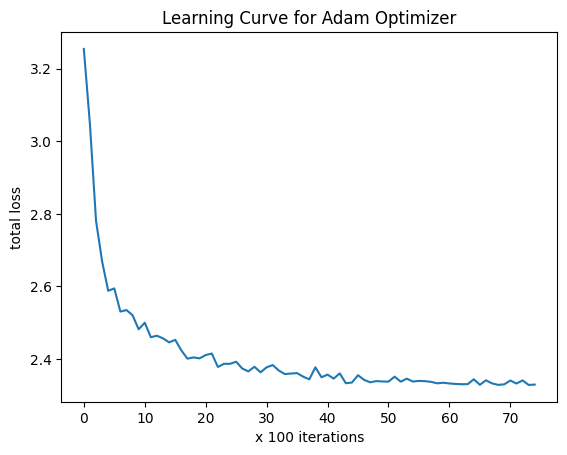

In [12]:
plt.plot(train_losses)
plt.xlabel('x 100 iterations')
plt.title('Learning Curve for Adam Optimizer')
plt.ylabel('total loss');

In [13]:
# create an instance of the model defined above
model = NeuralNetwork().to(device)
model.train()

# setting hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 15

# switching to SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_losses = []
test_losses = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses=train_losses, save_losses=True)
    test_loop(test_dataloader, model, loss_fn, test_losses=test_losses, save_losses=True)
    print()

epoch 1 ==================================================
train_loss: 2.5656890869140625
Train Accuracy: 36.56%
Test Accuracy: 44.02%

epoch 2 ==================================================
train_loss: 2.511042594909668
Train Accuracy: 58.14%
Test Accuracy: 48.81%

epoch 3 ==================================================
train_loss: 2.4442696571350098
Train Accuracy: 66.73%
Test Accuracy: 55.3%

epoch 4 ==================================================
train_loss: 2.421931743621826
Train Accuracy: 73.98%
Test Accuracy: 63.4%

epoch 5 ==================================================
train_loss: 2.3877463340759277
Train Accuracy: 79.85%
Test Accuracy: 66.63%

epoch 6 ==================================================
train_loss: 2.362750768661499
Train Accuracy: 84.57%
Test Accuracy: 68.21%

epoch 7 ==================================================
train_loss: 2.358513355255127
Train Accuracy: 87.61%
Test Accuracy: 69.92%

epoch 8 ==============================================

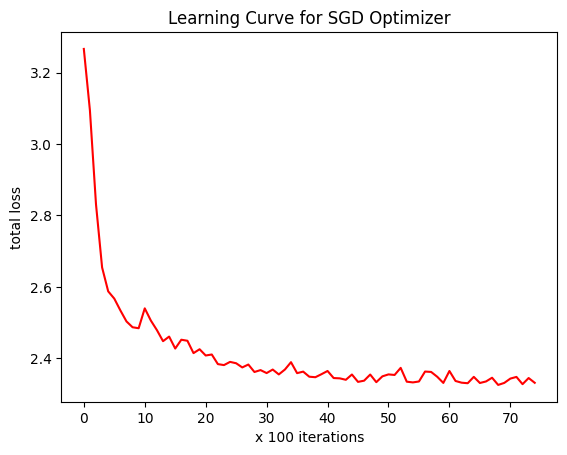

In [15]:
plt.plot(train_losses, color='red')
plt.xlabel('x 100 iterations')
plt.title('Learning Curve for SGD Optimizer')
plt.ylabel('total loss');

There is no major difference between the performance of the two algorithms except that the Adam converges a little bit faster than SGD.

#### C)

In [3]:
# neural network with dropout
class NeuralNetworkWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(784, affine=False),
            nn.Linear(784, 500),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(250, 60),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(60, 26),
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [17]:
# create an instance of the model defined above
model = NeuralNetworkWithDropout().to(device)
model.train()

# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# switching to SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
train_losses = []
test_losses = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses=train_losses, save_losses=True)
    test_loop(test_dataloader, model, loss_fn, test_losses=test_losses, save_losses=True)
    print()

epoch 1 ==================================================
train_loss: 2.5454888343811035
Train Accuracy: 46.06%
Test Accuracy: 52.7%

epoch 2 ==================================================
train_loss: 2.4220781326293945
Train Accuracy: 71.04%
Test Accuracy: 62.74%

epoch 3 ==================================================
train_loss: 2.3916144371032715
Train Accuracy: 81.18%
Test Accuracy: 67.97%

epoch 4 ==================================================
train_loss: 2.362708568572998
Train Accuracy: 88.14%
Test Accuracy: 70.5%

epoch 5 ==================================================
train_loss: 2.3796935081481934
Train Accuracy: 91.23%
Test Accuracy: 71.82%

epoch 6 ==================================================
train_loss: 2.3573198318481445
Train Accuracy: 93.95%
Test Accuracy: 72.52%

epoch 7 ==================================================
train_loss: 2.353760004043579
Train Accuracy: 94.97%
Test Accuracy: 75.88%

epoch 8 ============================================

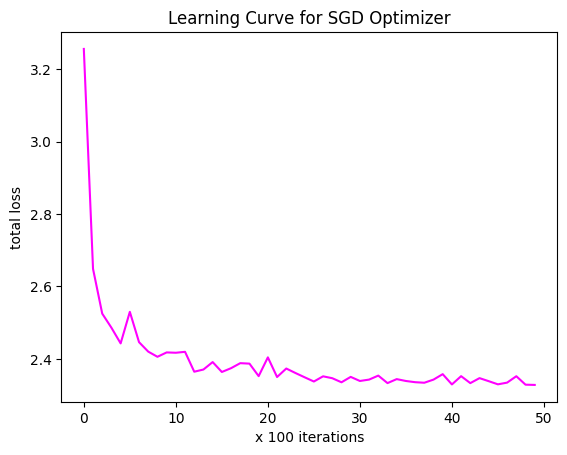

In [19]:
plt.plot(train_losses, color='magenta')
plt.xlabel('x 100 iterations')
plt.title('Learning Curve for SGD Optimizer')
plt.ylabel('total loss');

#### D)

Using dropout layers, algorithm converges more quickly, but, the accuracy is almost the same as before. Also, it acts as a regularization and prevents overfitting.

#### E)

In [4]:
model = torch.load('model1.pt')
cap = cv2.VideoCapture(0)
model.eval()

while True:
    
    ret, frame = cap.read()
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    input_img = cv2.resize(gray_img, (28, 28))
    input_img = torch.tensor(input_img).reshape((1, 28, 28)).to(device)
    y_pred = model(input_img.float())
    predicted_character = chr(65 + y_pred.argmax())
    cv2.putText(frame, predicted_character, (300, 400), 4, 3, (0, 255, 255))
    cv2.imshow('WebCam', frame)
    
    if cv2.waitKey(1) == ord('f'):
        break
    
cap.release()
cv2.destroyAllWindows()